# Detect a fish species using Fish Image Dataset

#### This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey for a university-industry collaboration project at Izmir University of Economics, and this work was published in ASYU 2020. Dataset includes, gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, black sea sprat, striped red mullet, trout, shrimp image samples. 

#### The dataset contains 9 different seafood types. For each class, there are 1000 augmented images and their pair-waise augmented ground truths.Each class can be found in the "Fish_Dataset" file with their ground truth labels. All images for each class are ordered from "00000.png" to "01000.png". For example, if you want to access the ground truth images of the shrimp in the dataset, the order should be followed is "Fish->Shrimp->Shrimp GT". 

#### This dataset was collected in order to carry out segmentation, feature extraction and classification tasks and compare the common segmentation, feature extraction and classification algortihms (Semantic Segmentation, Convolutional Neural Networks, Bag of Features). All of the experiment results prove the usability of our dataset for purposes mentioned above.

# Importing Libraries

In [16]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf
import matplotlib.pyplot as plt

### Setting the Directory for images

In [2]:
image_dir = Path('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

### Making a Dataframe with Image system paths as one column and the classes they belong to as labels as another column

In [3]:
# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df['Label'] = image_df['Label'].apply(lambda x: np.NaN if x[-2:] == 'GT' else x)
image_df = image_df.dropna(axis=0)

# Sample 200 images from each class
samples = []

for category in image_df['Label'].unique():
    category_slice = image_df.query("Label == @category")
    samples.append(category_slice.sample(200, random_state=1))

image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [4]:
image_df

,Filepath,Label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Gilt-Head Bream
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Sea Bass
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Mullet
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Shrimp
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Trout
...,...,...
1795,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Trout
1796,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
1797,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Striped Red Mullet
1798,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Black Sea Sprat


### Deviding the dataframe into Train and Test Dataframe

In [6]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Importing The Dataset Images

In [8]:
# making generators which will generate or load the dataset at runtime
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
# Finally using generators to make image datasets and readying it for model training

# Using train generator to take images for training
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

# Again using train generator to take images for validation now
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Using Test Generator to import images for 
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1008 validated image filenames belonging to 9 classes.
Found 252 validated image filenames belonging to 9 classes.
Found 540 validated image filenames belonging to 9 classes.


# Importing and using MobileNetV2 Model

In [10]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

2022-11-24 10:18:11.531834: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


9420800/9406464 [==============================] - 0s 0us/step


# Training the loaded Models

In [11]:
# Setting up the inputs
inputs = pretrained_model.input

# Making a Neural net for using the pretrained model and matching the input and output layer of the pretrained model with our data
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)


# Compiling the Custom Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Finally Training the Model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping( # Early stopping technique stops the model training when the model has received the best weights
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

2022-11-24 10:22:08.692322: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
32/32 [==============================] - 40s 1s/step - loss: 0.6748 - accuracy: 0.8185 - val_loss: 0.1559 - val_accuracy: 0.9563
Epoch 2/100
32/32 [==============================] - 26s 812ms/step - loss: 0.0877 - accuracy: 0.9762 - val_loss: 0.0792 - val_accuracy: 0.9841
Epoch 3/100
32/32 [==============================] - 26s 810ms/step - loss: 0.0320 - accuracy: 0.9931 - val_loss: 0.0527 - val_accuracy: 0.9921
Epoch 4/100
32/32 [==============================] - 26s 821ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0407 - val_accuracy: 0.9921
Epoch 5/100
32/32 [==============================] - 26s 806ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0458 - val_accuracy: 0.9921
Epoch 6/100
32/32 [==============================] - 26s 807ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 0.9921
Epoch 7/100
32/32 [==============================] - 26s 808ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0425 - val_accuracy: 0.

# Results

In [12]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.02404
Test Accuracy: 99.26%


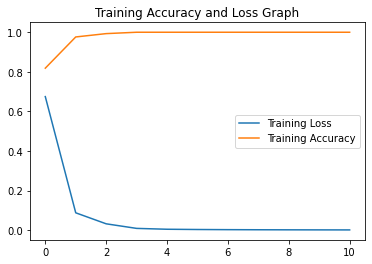

In [28]:
plt.title("Training Accuracy and Loss Graph")
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['accuracy'],label = 'Training Accuracy')
plt.legend()
plt.show()

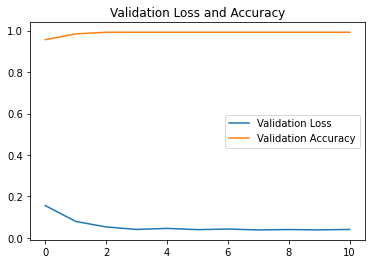

In [26]:
plt.title("Validation Loss and Accuracy")
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()